In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
repeat = 10

# MCAR

In [ ]:
class MCAR:
    def __init__(self, means, gamma):
        self.arm_means = means
        self.num_arms = len(means)
        self.gamma = gamma
        self.best_arm = np.argmax(means)

    def pull_arm(self, arm):
        reward = np.random.normal(self.arm_means[arm], 1)

        observed = np.random.rand() < self.gamma

        return (reward, observed) if observed else (None, observed)

In [ ]:
class MCAR_algo:
    def __init__(self, bandit_env, alpha):
        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.counts = np.zeros(self.num_arms)
        self.means = np.zeros(self.num_arms)
        self.total_pulls = 0
        self.alpha = alpha

    def select_arm(self, round_number):
        if self.total_pulls < self.num_arms:
            return self.total_pulls

        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                ucb_values[arm] = float('inf')
            else:
                confidence_bound = np.sqrt(self.alpha * np.log(round_number) / self.counts[arm])
                ucb_values[arm] = self.means[arm] + confidence_bound

        return np.argmax(ucb_values)

    def update(self, arm, reward, observed):
        if observed:
            self.counts[arm] += 1
            self.means[arm] += (reward - self.means[arm]) / self.counts[arm]

        self.total_pulls += 1

    def update_regret(self, arm, cu_regret, regrets):
        regret = self.bandit_env.arm_means[self.bandit_env.best_arm] - self.bandit_env.arm_means[arm]
        cu_regret += regret
        regrets.append(cu_regret)
        return cu_regret

    def run(self, num_rounds):
        results = []
        regrets = []
        cu_regret = 0
        for round_number in range(num_rounds):
            arm = self.select_arm(round_number)

            reward, observed = self.bandit_env.pull_arm(arm)

            cu_regret = self.update_regret(arm, cu_regret, regrets)
            self.update(arm, reward, observed)

            results.append((arm, reward, observed))

        return results, regrets

In [ ]:
np.random.seed(4)

n = 10  # Number of arms

means = np.random.uniform(0, 1, size=n)  # Means between 0 and 5
gamma = np.random.uniform(0.5, 1.0)  # Observation probabilities between 0.5 and 1

print(means)
print(gamma)

alpha = 2

mcar_env = MCAR(means, gamma)
ucb_alg = MCAR_algo(mcar_env, alpha)

T = 10000
results, regrets = ucb_alg.run(T)

[0.96702984 0.54723225 0.97268436 0.71481599 0.69772882 0.2160895
 0.97627445 0.00623026 0.25298236 0.43479153]
0.8896914608968762


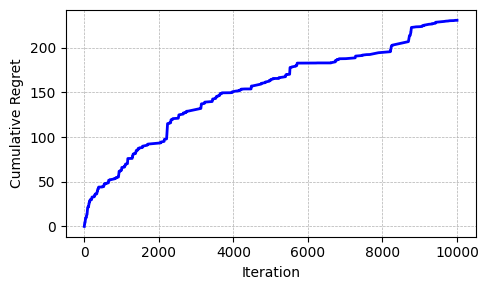

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(regrets, label='Cumulative Regret', color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
# plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Save the figure with high resolution
plt.tight_layout()
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

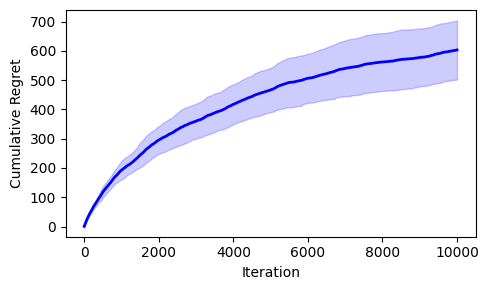

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Parameters
n = 10
T = 10000
alpha = 2
repeat = 20  # Number of repetitions

# Initialize cumulative regret matrix
cu_regret = np.zeros((repeat, T))

# Generating random means and gamma values with fixed seed
means = np.random.uniform(0, 1, size=n)  # Means between 0 and 1
gamma = np.random.uniform(0.5, 1.0)  # Observation probabilities between 0.5 and 1

# Initialize the MCAR environment
mcar_env = MCAR(means, gamma)

# Running the algorithm for 'repeat' number of times
for r in range(repeat):
    # Setting seed for each repetition for consistent runs
    np.random.seed(42 + r)

    ucb_alg = MCAR_algo(mcar_env, alpha)
    results, regrets = ucb_alg.run(T)
    cu_regret[r] = regrets

# Calculate mean and standard deviation of cumulative regrets
mean_regret = np.mean(cu_regret, axis=0)
std_regret = np.std(cu_regret, axis=0)

# Plot suitable for a paper
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret, label='Cumulative Regret', color='blue', linewidth=2)

# Add shaded area for error indication (1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret - std_regret,
                 mean_regret + std_regret,
                 color='blue', alpha=0.2, label='±1 Std Dev')

# Labeling and formatting
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
plt.grid(False)  # You can enable the grid by changing this to True

# Save the figure with high resolution
plt.tight_layout()
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

In [ ]:
print(gamma)

0.5102922471479012


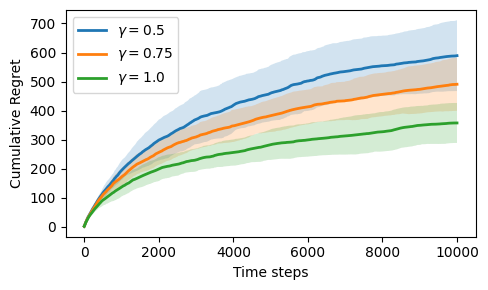

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Parameters
n = 10
T = 10000
alpha = 2
repeat = 20  # Number of repetitions
gamma_values = [0.5, 0.75, 1.0]  # Gamma values to use in the experiment

# Generate the same means for all experiments
means = np.random.uniform(0, 1, size=n)  # Means between 0 and 1

# Prepare to store cumulative regret for each gamma value
cu_regret_gamma = np.zeros((len(gamma_values), repeat, T))

# Loop through each gamma value
for idx, gamma in enumerate(gamma_values):
    for r in range(repeat):
        # Create the MCAR environment with the same means but different gamma
        # Set a seed for each repetition to make the experiment reproducible
        np.random.seed(42 + r + idx * repeat)  # Unique seed per gamma and repetition

        mcar_env = MCAR(means, gamma)

        # Run the MCAR algorithm
        ucb_alg = MCAR_algo(mcar_env, alpha)
        results, regrets = ucb_alg.run(T)

        # Store the regrets for this repetition
        cu_regret_gamma[idx, r] = regrets

# Plot the cumulative regrets for different gamma values with error shading
plt.figure(figsize=(5, 3))

# Loop over gamma values to plot
for idx, gamma in enumerate(gamma_values):
    mean_regret = np.mean(cu_regret_gamma[idx], axis=0)  # Mean cumulative regret
    std_regret = np.std(cu_regret_gamma[idx], axis=0)  # Standard deviation of cumulative regret

    # Plot the mean cumulative regret
    plt.plot(mean_regret, label=fr'$\gamma = {gamma}$', linewidth=2)

    # Add shaded area for error indication (1 standard deviation)
    plt.fill_between(np.arange(T),
                     mean_regret - std_regret,
                     mean_regret + std_regret,
                     alpha=0.2)

# Labeling and formatting
plt.xlabel('Time steps')
plt.ylabel('Cumulative Regret')

# Add LaTeX formatted legend
plt.legend(loc='upper left')

# Plot settings
plt.grid(False)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('cumulative_regret_gamma_values_same_means.png', dpi=300)

# Display the plot
plt.show()

#UCB

In [ ]:
class UCB_algo:
    def __init__(self, bandit_env, alpha):
        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.counts = np.zeros(self.num_arms)
        self.means = np.zeros(self.num_arms)
        self.total_pulls = 0
        self.alpha = alpha

    def select_arm(self, round_number):
        if self.total_pulls < self.num_arms:
            return self.total_pulls

        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                ucb_values[arm] = float('inf')
            else:
                confidence_bound = np.sqrt(self.alpha / 2 * np.log(self.total_pulls) / self.counts[arm])
                ucb_values[arm] = self.means[arm] + confidence_bound

        return np.argmax(ucb_values)

    def update(self, arm, reward, observed):
        if observed:
            self.counts[arm] += 1
            self.means[arm] += (reward - self.means[arm]) / self.counts[arm]

        self.total_pulls += 1

    def update_regret(self, arm, cu_regret, regrets):
        regret = np.sum(self.bandit_env.p[self.bandit_env.best_arm] * self.bandit_env.means[self.bandit_env.best_arm]) - np.sum(self.bandit_env.p[arm] * self.bandit_env.means[arm])
        cu_regret += regret
        regrets.append(cu_regret)
        return cu_regret

    def run(self, num_rounds):
        results = []
        regrets = []
        cu_regret = 0
        for round_number in range(num_rounds):
            arm = self.select_arm(round_number)

            reward, observed, context = self.bandit_env.pull_arm(arm)

            cu_regret = self.update_regret(arm, cu_regret, regrets)
            self.update(arm, reward, observed)

            results.append((arm, reward, observed))

        return results, regrets

#MAR

In [ ]:
import numpy as np

class MAR:
    def __init__(self, means, gamma, prob):
        self.means = means
        self.gamma = gamma
        self.p = prob
        self.num_arms = means.shape[0]  # Number of arms (n)
        self.num_contexts = means.shape[1]  # Number of contexts (k)
        self.best_arm = np.argmax(np.sum(self.p * self.means , axis=1))

    def pull_arm(self, arm):
        if arm >= self.num_arms:
            raise ValueError("Invalid arm index")

        # Select a context based on the probability distribution p[arm]
        context = np.random.choice(self.num_contexts, p=self.p[arm])

        # Reward is drawn from a normal distribution centered at the means[arm, context]
        reward = np.random.normal(self.means[arm, context], 1)

        # Determine if the reward is observed based on the gamma[arm, context]
        observed = np.random.rand() < self.gamma[arm, context]
        if observed:
            return reward, observed, context
        else:
            return None, observed, context

In [ ]:
class MAR_algo:
    def __init__(self, bandit_env, alpha, p_known):

        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.num_contexts = bandit_env.num_contexts
        # self.p = bandit_env.p
        self.alpha = alpha
        self.p_known = p_known
        self.p = np.zeros((self.num_arms, self.num_contexts))

        self.counts = np.zeros((self.num_arms, self.num_contexts))  # Keeps track of how many times each arm-context pair has been pulled
        self.means = np.zeros((self.num_arms, self.num_contexts))  # Estimate of the mean reward for each arm-context pair
        self.s = np.zeros((self.num_arms, self.num_contexts))

    def select_arm(self, round_number):

        # Calculate UCB values for each arm based on all contexts
        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.p_known:
              self.p = bandit_env.p
            else:
              self.p[arm, :] = self.s[arm, :] / np.sum(self.counts[arm])

            if np.any(self.counts[arm] == 0):
                ucb_values[arm] = float('inf')  # If no context has been explored for this arm, set UCB to infinity
            else:
                # Calculate the mean reward over all contexts weighted by pulls
                mean_reward = np.sum(self.p[arm] * self.means[arm])

                # UCB confidence bound using total counts
                if self.p_known:
                  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
                else:
                  confidence_bound = 8 * np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
                ucb_values[arm] = mean_reward + confidence_bound

        # Select the arm with the highest UCB value
        return np.argmax(ucb_values)

    def update(self, arm, context, reward, observed):
        self.s[arm, context] += 1

        if observed:
            # Increment the count for the pulled arm-context pair
            self.counts[arm, context] += 1

            # Update the estimated mean reward for this arm-context pair
            self.means[arm, context] = (reward + self.means[arm, context] * (self.counts[arm, context] - 1)) / self.counts[arm, context]

    def update_regret(self, arm, context, cu_regret, regrets):

        regret = np.sum(self.bandit_env.p[self.bandit_env.best_arm] * self.bandit_env.means[self.bandit_env.best_arm]) - np.sum(self.bandit_env.p[arm] * self.bandit_env.means[arm])

        cu_regret += regret  # Add this round's regret to the cumulative regret
        regrets.append(cu_regret)  # Store the cumulative regret
        return cu_regret

    def run(self, num_rounds):

        results = []
        regrets = []
        cu_regret = 0

        for arm in range(self.num_arms):
          for _ in range(int(np.log(num_rounds)**2)):
            reward, observed, context = self.bandit_env.pull_arm(arm)
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)
            self.update(arm, context, reward, observed)
            results.append((arm, reward, observed, context))

        for round_number in range(num_rounds - self.num_arms * int(np.log(num_rounds)**2)):
            # Select an arm using the UCB strategy
            arm = self.select_arm(round_number)

            # Pull the arm and observe the reward and context
            reward, observed, context = self.bandit_env.pull_arm(arm)

            # Update the cumulative regret and store the result
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)

            # Update the means and counts based on the observed reward
            self.update(arm, context, reward, observed)

            # Store the results for this round
            results.append((arm, reward, observed, context))

        return results, regrets

##test

In [ ]:
np.random.seed(5)

n = 10  # Number of arms
k = 5   # Number of contexts

means = np.random.uniform(0, 0.5, size=(n, k))
means[0] = means[0] + 0.2
gamma = np.random.uniform(0.2, 1.0, size=(n, k))

# Randomly generate a probability matrix for the categorical distribution (each row sums to 1)
p = np.random.dirichlet(np.ones(k), size=n)

bandit_env = MAR(means, gamma, p)

alpha = 1
p_known = 1
algo = MAR_algo(bandit_env, alpha, p_known)

In [ ]:
np.random.seed(42)
T = 50000
results, regrets1 = algo.run(T)

<ipython-input-13-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-13-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


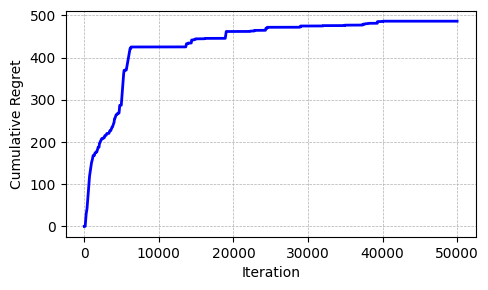

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(regrets1, label='Cumulative Regret', color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
# plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Save the figure with high resolution
plt.tight_layout()
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

##UCB on MAR env

In [ ]:
# bandit_env = MAR(means, gamma, p)
np.random.seed(42)
algo = UCB_algo(bandit_env, alpha)
results, regrets2 = algo.run(50000)

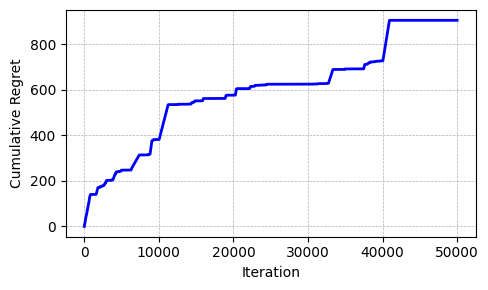

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(regrets2, label='Cumulative Regret', color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
# plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Save the figure with high resolution
plt.tight_layout()
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

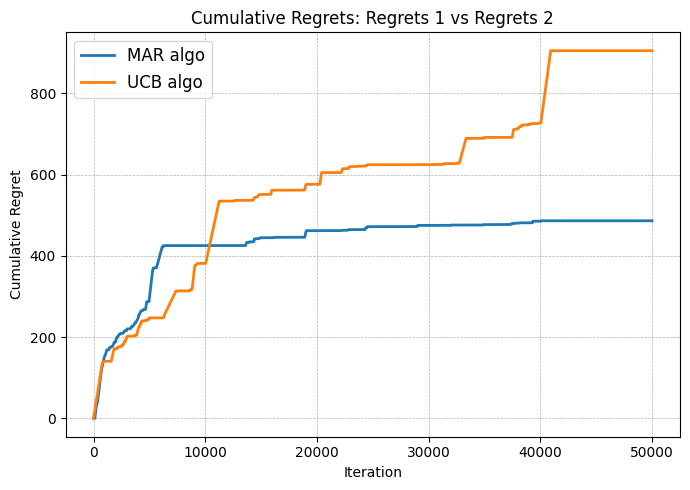

In [ ]:
# Plot the regrets on the same figure
plt.figure(figsize=(7, 5))

# Plot regrets1
plt.plot(regrets1, label='MAR algo', linewidth=2)

# Plot regrets2
plt.plot(regrets2, label='UCB algo', linewidth=2)

# Plot settings
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regrets: Regrets 1 vs Regrets 2')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and display the plot
plt.tight_layout()
plt.savefig('regrets1_vs_regrets2.png', dpi=300)
plt.show()


##UCB on MAR repeating

<ipython-input-13-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-13-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


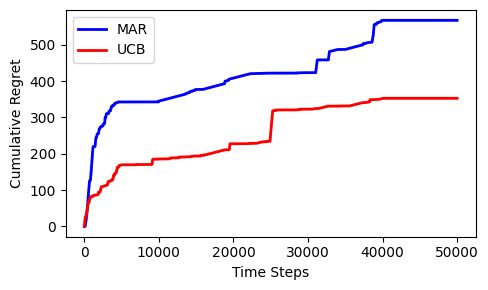

In [ ]:
# Seed for reproducibility
np.random.seed(42)

# Number of arms and contexts
n = 10
k = 5

# Generate the means and gamma
means = np.random.uniform(0, 0.5, size=(n, k))
means[0] = means[0] + 0.2
gamma = np.random.uniform(0.4, 0.6, size=(n, k))

# Randomly generate a probability matrix for the categorical distribution
p = np.random.dirichlet(np.ones(k), size=n)

# Bandit environment setup
bandit_env = MAR(means, gamma, p)

# Algorithm parameters
alpha = 1
p_known = 1
T = 50000  # Time horizon
num_repeats = 1  # Number of repetitions to average over

# Initialize arrays to store the cumulative regrets
regrets1_avg = np.zeros(T)
regrets2_avg = np.zeros(T)
regrets1_all = np.zeros((num_repeats, T))
regrets2_all = np.zeros((num_repeats, T))

# Loop over the number of repeats
for i in range(num_repeats):
    # MAR Algorithm
    algo1 = MAR_algo(bandit_env, alpha, p_known)
    _, regrets1 = algo1.run(T)
    regrets1_avg += regrets1
    regrets1_all[i] = regrets1

    # UCB Algorithm
    np.random.seed(42 + i)  # Change the seed for each repeat
    algo2 = UCB_algo(bandit_env, alpha)
    _, regrets2 = algo2.run(T)
    regrets2_avg += regrets2
    regrets2_all[i] = regrets2

# Average the regrets over the number of repetitions
regrets1_avg /= num_repeats
regrets2_avg /= num_repeats

# Calculate standard deviation for error shading
std_regrets1 = np.std(regrets1_all, axis=0)
std_regrets2 = np.std(regrets2_all, axis=0)

# Plot the averaged regrets with error shading
plt.figure(figsize=(5, 3))

# Plot MAR Algorithm cumulative regret
plt.plot(regrets1_avg, label=r'MAR', color='blue', linewidth=2)
plt.fill_between(np.arange(T), regrets1_avg - std_regrets1, regrets1_avg + std_regrets1, color='blue', alpha=0.2)

# Plot UCB Algorithm cumulative regret
plt.plot(regrets2_avg, label=r'UCB', color='red', linewidth=2)
plt.fill_between(np.arange(T), regrets2_avg - std_regrets2, regrets2_avg + std_regrets2, color='red', alpha=0.2)

# Labeling and formatting
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')

# LaTeX formatted legend
plt.legend(loc='upper left')

# Grid and layout
plt.grid(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('cumulative_regret_MAR_vs_UCB.png', dpi=300)
plt.show()

In [ ]:
import numpy as np

class MAR:
    def __init__(self, means, gamma, prob):
        self.means = means
        self.gamma = gamma
        self.p = prob
        self.num_arms = means.shape[0]  # Number of arms (n)
        self.num_contexts = means.shape[1]  # Number of contexts (k)
        self.best_arm = np.argmax(np.sum(self.p * self.means , axis=1))

    def pull_arm(self, arm):
        if arm >= self.num_arms:
            raise ValueError("Invalid arm index")

        # Select a context based on the probability distribution p[arm]
        context = int(np.random.choice(self.num_contexts, p=self.p[arm]))

        # Reward is drawn from a normal distribution centered at the means[arm, context]
        reward = float(np.random.normal(self.means[arm, context], 1))

        # Determine if the reward is observed based on the gamma[arm, context]
        observed = np.random.rand() < self.gamma[arm, context]
        if observed:
            return reward, observed, context
        else:
            return None, observed, context

In [ ]:
# Seed for reproducibility
np.random.seed(42)

# Number of arms and contexts
n = 10
k = 5

# Generate the means and gamma
means = np.random.uniform(0, 0.5, size=(n, k))
for i in range(n):
  means[i, 0] = np.random.uniform(0.8, 1, size=(1))

# Randomly generate a probability matrix for the categorical distribution
p = np.full((n, k), 1 / k)

peak_index = 0  # Randomly choose a peak index
alpha_values = np.ones(k)
alpha_values[peak_index] = 10  # Bias alpha to create a peak at the chosen index
p[0, :] = np.random.dirichlet(alpha_values)

gamma = np.random.uniform(0.5, 0.8, size=(n, k))
for i in range(n):
  for j in range(k):
    gamma[i, j] = 1 / p[i, j]
gamma = gamma / gamma.sum(axis=1, keepdims=True)


# Bandit environment setup
bandit_env = MAR(means, gamma, p)

<ipython-input-22-075c4455024e>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  means[i, 0] = np.random.uniform(0.8, 1, size=(1))


<ipython-input-13-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-13-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


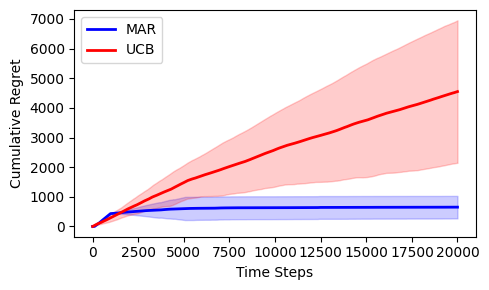

In [ ]:
np.random.seed(42)

# Algorithm parameters
alpha = 1
p_known = 1
T = 20000  # Time horizon
num_repeats = 20  # Number of repetitions to average over

# Initialize arrays to store the cumulative regrets
regrets1_avg = np.zeros(T)
regrets2_avg = np.zeros(T)
regrets1_all = np.zeros((num_repeats, T))
regrets2_all = np.zeros((num_repeats, T))

# Loop over the number of repeats
for i in range(num_repeats):
    # MAR Algorithm
    algo1 = MAR_algo(bandit_env, alpha, p_known)
    _, regrets1 = algo1.run(T)
    regrets1_avg += regrets1
    regrets1_all[i] = regrets1

    # UCB Algorithm
    algo2 = UCB_algo(bandit_env, alpha)
    _, regrets2 = algo2.run(T)
    regrets2_avg += regrets2
    regrets2_all[i] = regrets2

# Average the regrets over the number of repetitions
regrets1_avg /= num_repeats
regrets2_avg /= num_repeats

# Calculate standard deviation for error shading
std_regrets1 = np.std(regrets1_all, axis=0)
std_regrets2 = np.std(regrets2_all, axis=0)

# Plot the averaged regrets with error shading
plt.figure(figsize=(5, 3))

# Plot MAR Algorithm cumulative regret
plt.plot(regrets1_avg, label=r'MAR', color='blue', linewidth=2)
plt.fill_between(np.arange(T), regrets1_avg - std_regrets1, regrets1_avg + std_regrets1, color='blue', alpha=0.2)

# Plot UCB Algorithm cumulative regret
plt.plot(regrets2_avg, label=r'UCB', color='red', linewidth=2)
plt.fill_between(np.arange(T), regrets2_avg - std_regrets2, regrets2_avg + std_regrets2, color='red', alpha=0.2)

# Labeling and formatting
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')

# LaTeX formatted legend
plt.legend(loc='upper left')

# Grid and layout
plt.grid(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('cumulative_regret_MAR_vs_UCB.png', dpi=300)
plt.show()

##different Ps

<ipython-input-13-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-13-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


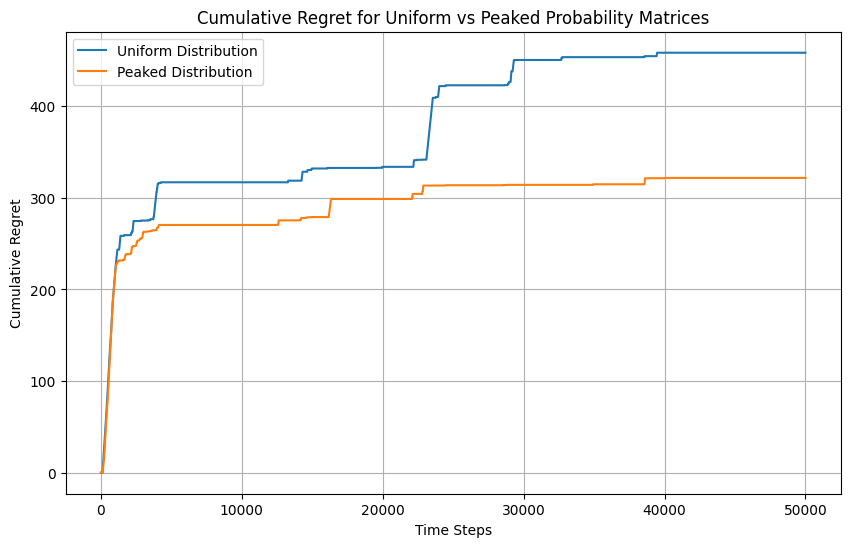

In [ ]:
# Set up common parameters
np.random.seed(5)

n = 10  # Number of arms
k = 5   # Number of contexts

# Generate means and gamma values
means = np.random.uniform(0, 0.5, size=(n, k))  # Means between 0 and 1
means[0] = means[0] + 0.2
gamma = np.random.uniform(0.2, 1.0, size=(n, k))  # Observation probabilities

alpha = 1
p_known = 1
T = 50000  # Time steps

# Initialize list for probability matrices
p_list = []

# First p: Uniform distribution for each row
p_uniform = np.full((n, k), 1 / k)
p_list.append(p_uniform)

# Second p: Peaked distributions using Dirichlet
p_peaked = np.zeros((n, k))
for i in range(n):
    peak_index = np.random.randint(0, k)  # Randomly choose a peak index
    alpha_values = np.ones(k)
    alpha_values[peak_index] = 5  # Bias alpha to create a peak at the chosen index
    p_peaked[i, :] = np.random.dirichlet(alpha_values)
p_list.append(p_peaked)

# Prepare plot
plt.figure(figsize=(10, 6))

# Labels for the probability matrices
p_labels = ["Uniform Distribution", "Peaked Distribution"]

# Run the algorithm for each p and plot results
for idx, p in enumerate(p_list):
    # Initialize the bandit environment and algorithm
    bandit_env = MAR(means, gamma, p)
    algo = MAR_algo(bandit_env, alpha, p_known)

    # Run the algorithm
    np.random.seed(42)  # Ensure same randomness for fair comparison
    results, regrets = algo.run(T)

    # Plot the cumulative regret for each probability matrix
    plt.plot(regrets, label=p_labels[idx])

# Finalize the plot
plt.title('Cumulative Regret for Uniform vs Peaked Probability Matrices')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

##different Ps repeated

<ipython-input-13-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-13-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


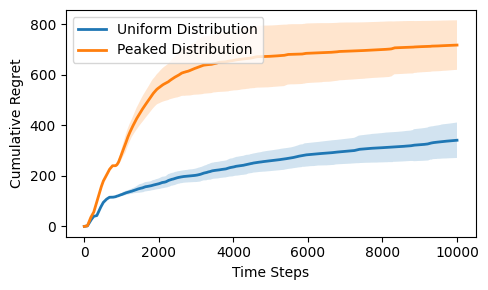

In [ ]:
np.random.seed(42)
# Set up common parameters
n = 10  # Number of arms
k = 5   # Number of contexts
T = 10000  # Time steps
num_repeats = 10  # Number of runs to average over

# Generate means and gamma values
np.random.seed(2)  # Set seed for reproducibility
means = np.random.uniform(0, 0.8, size=(n, k))  # Means between 0 and 1
means[0] = means[0] + 0.2
gamma = np.random.uniform(0.2, 1.0, size=(n, k))  # Observation probabilities

alpha = 1
p_known = 1

# Initialize list for probability matrices
p_list = []

# First p: Uniform distribution for each row
p_uniform = np.full((n, k), 1 / k)
p_list.append(p_uniform)

# Second p: Peaked distributions using Dirichlet
p_peaked = np.zeros((n, k))
for i in range(n):
    peak_index = np.random.randint(0, k)  # Randomly choose a peak index
    alpha_values = np.ones(k)
    alpha_values[peak_index] = 5  # Bias alpha to create a peak at the chosen index
    p_peaked[i, :] = np.random.dirichlet(alpha_values)
p_list.append(p_peaked)

# Labels for the probability matrices
p_labels = ["Uniform Distribution", "Peaked Distribution"]

# Prepare storage for average regrets and standard deviations
avg_regrets_list = []
std_regrets_list = []

# Run multiple times for both uniform and peaked probability matrices
for idx, p in enumerate(p_list):
    # Store the cumulative regrets over multiple runs
    cumulative_regrets_runs = np.zeros((num_repeats, T))

    for run in range(num_repeats):
        # Initialize the bandit environment and algorithm
        bandit_env = MAR(means, gamma, p)
        algo = MAR_algo(bandit_env, alpha, p_known)

        # Run the algorithm
        results, regrets = algo.run(T)

        # Store the cumulative regret for this run
        cumulative_regrets_runs[run, :] = regrets

    # Calculate the average and standard deviation of cumulative regret over all runs
    avg_cumulative_regrets = np.mean(cumulative_regrets_runs, axis=0)
    std_cumulative_regrets = np.std(cumulative_regrets_runs, axis=0)

    avg_regrets_list.append(avg_cumulative_regrets)
    std_regrets_list.append(std_cumulative_regrets)

# Plot the average cumulative regrets with error shading for both cases
plt.figure(figsize=(5, 3))

for idx, avg_cumulative_regrets in enumerate(avg_regrets_list):
    # Plot the mean cumulative regret
    plt.plot(avg_cumulative_regrets, label=f'{p_labels[idx]}', linewidth=2)

    # Add shaded area for error indication (1 standard deviation)
    plt.fill_between(np.arange(T),
                     avg_cumulative_regrets - std_regrets_list[idx],
                     avg_cumulative_regrets + std_regrets_list[idx],
                     alpha=0.2)

# Finalize the plot
# plt.title('Average Cumulative Regret for Uniform vs Peaked Probability Matrices')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.legend(loc='upper left')
plt.grid(False)

# Adjust layout and save the figure with high resolution
plt.tight_layout()
plt.savefig('average_cumulative_regret_uniform_vs_peaked.png', dpi=300)

# Display the plot
plt.show()

repeating

<ipython-input-13-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-13-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


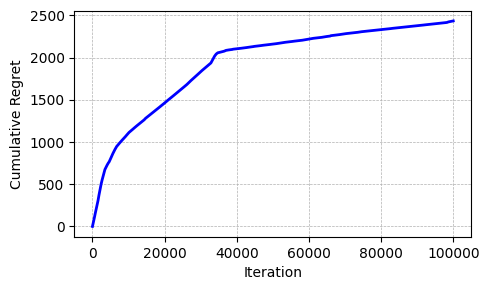

In [ ]:
T = 100000
n = 10  # Number of arms
k = 10   # Number of contexts
alpha = 1
p_known = 1
repeat = 10

cu_regret = np.zeros((repeat,T))
for r in range(repeat):

  means = np.random.uniform(0, 1, size=(n, k))  # Means between 0 and 5
  gamma = np.random.uniform(0.5, 1.0, size=(n, k))  # Observation probabilities between 0.5 and 1
  p = np.random.dirichlet(np.ones(k), size=n)  # Each row is a probability distribution over contexts

  bandit_env = MAR(means, gamma, p)

  algo = MAR_algo(bandit_env, alpha, p_known)
  results, regrets = algo.run(T)

  cu_regret[r] = regrets

plt.figure(figsize=(5, 3))
plt.plot(np.mean(cu_regret, axis=0), label='Cumulative Regret', color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
# plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Save the figure with high resolution
plt.tight_layout()
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

In [ ]:
# Parameters
T = 100000  # Time horizon
n = 10  # Number of arms
k = 20  # Number of contexts
alpha = 1
p_known = 1
repeat = 20  # Number of repetitions

# Initialize cumulative regret storage
cu_regret = np.zeros((repeat, T))

# Set a seed for reproducibility
np.random.seed(2)

# Generate random means and gamma values
means = np.random.uniform(0, 0.5, size=(n, k))  # Means between 0 and 1
means += 0.2*np.eye(n, k)
gamma = np.random.uniform(0.5, 1.0, size=(n, k))  # Observation probabilities between 0.5 and 1
p = np.random.dirichlet(np.ones(k), size=n)  # Each row is a probability distribution over contexts

# Initialize the MAR bandit environment
bandit_env = MAR(means, gamma, p)

# Run the algorithm for each repetition
for r in range(repeat):
    # Set a unique seed for each run to ensure variability between runs
    np.random.seed(42 + r)

    # Initialize the MAR algorithm and run it
    algo = MAR_algo(bandit_env, alpha, p_known)
    results, regrets = algo.run(T)

    # Store the cumulative regrets for this run
    cu_regret[r] = regrets

# Calculate mean and standard deviation of cumulative regrets
mean_regret = np.mean(cu_regret, axis=0)
std_regret = np.std(cu_regret, axis=0)

# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret, label='Cumulative Regret', color='blue', linewidth=2)

# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret - std_regret,
                 mean_regret + std_regret,
                 color='blue', alpha=0.2, label='±1 Std Dev')

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.grid(False)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

## MAR With unknown p

In [ ]:
np.random.seed(42)

# Number of arms and contexts
n = 10
k = 5

# Generate the means and gamma
means = np.random.uniform(0, 0.4, size=(n, k))
means[0] = means[0] + 0.6

# Randomly generate a probability matrix for the categorical distribution
p = np.random.dirichlet(np.ones(k), size=n)

gamma = np.random.uniform(0.8, 1.0, size=(n, k))  # Observation probabilities

# Bandit environment setup
bandit_env = MAR(means, gamma, p)

In [ ]:
np.random.seed(42)

# Parameters
T = 100000  # Time horizon
n = 10  # Number of arms
k = 5  # Number of contexts
alpha = 1
p_known = 0
repeat = 10  # Number of repetitions

# Initialize cumulative regret storage
cu_regret1 = np.zeros((repeat, T))

# Run the algorithm for each repetition
for r in range(repeat):
    # Initialize and run the MAR algorithm
    algo = MAR_algo(bandit_env, alpha, p_known)
    results, regrets = algo.run(T)

    # Store the cumulative regrets for this run
    cu_regret1[r] = regrets

cu_regret2 = np.zeros((repeat, T))
for r in range(repeat):
    # Initialize and run the MAR algorithm
    algo = MAR_algo(bandit_env, alpha, 1)
    results, regrets = algo.run(T)

    # Store the cumulative regrets for this run
    cu_regret2[r] = regrets

# Calculate mean and standard deviation of cumulative regrets
mean_regret1 = np.mean(cu_regret1, axis=0)
std_regret1 = np.std(cu_regret1, axis=0)

mean_regret2 = np.mean(cu_regret2, axis=0)
std_regret2 = np.std(cu_regret2, axis=0)



# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret1, label='unknown p', color='red', linewidth=2)

plt.plot(mean_regret2, label='known p', color='blue', linewidth=2)


# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret1 - std_regret1,
                 mean_regret1 + std_regret1,
                 color='red', alpha=0.2, label='±1 Std Dev')

plt.fill_between(np.arange(T),
                 mean_regret2 - std_regret2,
                 mean_regret2 + std_regret2,
                 color='blue', alpha=0.2, label='±1 Std Dev')

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))

T = 100000

# Plot the mean cumulative regret
plt.plot(mean_regret1, label='unknown p')

# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret1 - std_regret1,
                 mean_regret1 + std_regret1, alpha=0.2)

plt.plot(mean_regret2, label='known p')

plt.fill_between(np.arange(T),
                 mean_regret2 - std_regret2,
                 mean_regret2 + std_regret2, alpha=0.2)

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)
plt.legend(loc='upper left')

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

# MNAR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MNAR:
    def __init__(self, means, gamma, prob, rewards):
        self.means = means
        self.gamma = gamma
        self.p = prob
        self.num_arms = means.shape[0]  # Number of arms (n)
        self.num_contexts = means.shape[1]  # Number of contexts (k)
        self.num_reward = means.shape[1]
        self.rewards = rewards
        self.mu = np.zeros((self.num_arms))
        self.best_arm = -1
        self.best_mu = -1

        for a in range(self.num_arms):
          mu = 0
          for m in range(self.num_contexts):
            for y in range(self.num_reward):
              mu += self.p[a, m] * self.means[a, m, y] * self.rewards[y]

          self.mu[a] = mu
          if mu > self.best_mu:
            self.best_mu = mu
            self.best_arm = a

        self.A_matrix = np.zeros((self.num_arms, self.num_contexts, self.num_reward))
        for a in range(self.num_arms):
          for m in range(self.num_contexts):
            for y in range(self.num_reward):
              self.A_matrix[a, m, y] = prob[a, m] * means[a, m, y] * gamma[a, y]
        self.k_A = [np.linalg.cond(self.A_matrix[a]) for a in range(self.num_arms)]

    def pull_arm(self, arm):
        if arm >= self.num_arms:
            raise ValueError("Invalid arm index")

        # Select a context based on the probability distribution p[arm]
        context = int(np.random.choice(self.num_contexts, p=self.p[arm]))

        # Reward is drawn from a normal distribution centered at the means[arm, context]
        reward_i = np.random.choice([i for i in range(self.num_reward)], p=list(self.means[arm, context]))
        reward = self.rewards[reward_i]

        # Determine if the reward is observed based on the gamma[arm, context]
        observed = np.random.rand() < self.gamma[arm, reward_i]
        if observed:
            return reward_i, reward, observed, context
        else:
            return None, None, observed, context

In [ ]:
class MNAR_algo:
    def __init__(self, bandit_env):

        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.num_contexts = bandit_env.num_contexts
        self.num_rewards = bandit_env.num_reward
        self.k_A = bandit_env.k_A
        self.rewards_value = bandit_env.rewards

        self.m0_matrix = np.zeros((bandit_env.num_arms, bandit_env.num_contexts))
        self.my1_matrix = np.zeros((bandit_env.num_arms, bandit_env.num_contexts, bandit_env.num_reward))
        self.my_given_1_matrix = np.zeros((bandit_env.num_arms, bandit_env.num_contexts, bandit_env.num_reward))

        self.T_a = np.zeros(bandit_env.num_arms)
        self.n_a = np.zeros(bandit_env.num_arms)


    def select_arm(self, round_number):
        ucb_values = np.zeros(self.num_arms)
        means = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
          m0_vector = self.m0_matrix[arm]/self.T_a[arm] # K * 1
          my1_matrix = self.my1_matrix[arm]/self.T_a[arm] # K * L
          my_given_1_matrix = self.my_given_1_matrix[arm]/self.n_a[arm] # K * L
          #################
          if np.linalg.det(my1_matrix) == 0:
            ucb_values[arm] = float('inf')
            means[arm] = float('inf')
          else:
            inverse_mymatrix = np.linalg.inv(my1_matrix)
            OR_vector = inverse_mymatrix @ m0_vector
            Ov_gamma_vector = OR_vector + 1 # L * 1
            my_a_matrx = np.zeros((bandit_env.num_contexts, bandit_env.num_reward))
            for i in range(bandit_env.num_contexts):
              for j in range(bandit_env.num_reward):
                my_a_matrx[i, j] = my_given_1_matrix[i, j] * Ov_gamma_vector[j]

            y_a_vector = np.zeros((bandit_env.num_reward))
            for j in range(bandit_env.num_reward):
              for i in range(bandit_env.num_contexts):
                y_a_vector[j] += my_a_matrx[i, j]

            mean = sum(y_a_vector * self.rewards_value)

            cb1 = (self.k_A[arm] / np.linalg.norm(my1_matrix, ord=np.inf)) * np.sqrt(np.log(round_number) / (2 * self.T_a[arm]))
            cb2 = self.num_contexts * np.sqrt(np.log(round_number) / (2 * self.n_a[arm]))

            cb = cb1 + cb2
            means[arm] = mean
            ucb_values[arm] = mean + 100 * cb

        arm = np.argmax(ucb_values)

        return arm, means[arm], ucb_values[arm]

    def update(self, arm, context, reward_i, reward, observed):
        int_obs = 1 if observed else 0
        self.T_a[arm] += 1
        self.n_a[arm] += int_obs
        if observed:
          self.m0_matrix[arm, context] += 1
          self.my1_matrix[arm, context, reward_i] += 1
          self.my_given_1_matrix[arm, context, reward_i] += 1

    def update_regret(self, arm, context, cu_regret, regrets):
        regret = self.bandit_env.mu[self.bandit_env.best_arm] - self.bandit_env.mu[arm]

        cu_regret += regret  # Add this round's regret to the cumulative regret
        regrets.append(cu_regret)  # Store the cumulative regret
        return cu_regret

    def run(self, num_rounds):

        results = []
        regrets = []
        cu_regret = 0

        for arm in range(self.num_arms):
          for _ in range(100):
            reward_i, reward, observed, context = self.bandit_env.pull_arm(arm)
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)
            self.update(arm, context, reward_i, reward, observed)

        for round_number in range(num_rounds - (100 * self.num_arms)):
            # Select an arm using the UCB strategy
            arm, mean, ucb = self.select_arm(round_number)

            # Pull the arm and observe the reward and context
            reward_i, reward, observed, context = self.bandit_env.pull_arm(arm)

            # Update the cumulative regret and store the result
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)

            # Update the means and counts based on the observed reward
            self.update(arm, context, reward_i, reward, observed)

            # Store the results for this round
            results.append((arm, mean, ucb, reward, observed, context))

        return results, regrets

-------


In [ ]:
np.random.seed(97)

# Number of arms and contexts
n = 5
k = 5
Y = 5

# Generate the means and gamma
means = np.zeros((n, k, Y))
for i in range(n):
  for j in range(k):
    means[i, j] = np.random.dirichlet(np.ones(k), size=1)

for j in range(k):
    peak_index = 1 # Randomly choose a peak index
    alpha_values = np.ones(k)
    alpha_values[peak_index] = 20  # Bias alpha to create a peak at the chosen index
    means[2, j] = np.random.dirichlet(alpha_values)

# Randomly generate a probability matrix for the categorical distribution
p = np.random.dirichlet(np.ones(k), size=n)

gamma = np.random.uniform(0.5, 1.0, size=(n, Y))  # Observation probabilities

rewards = [0.3, 1, 0.4, 0.3, 0.2]
rewards = [x * 1000 for x in rewards]
# rewards = [0.1, 0.9]

# Bandit environment setup
bandit_env = MNAR(means, gamma, p, rewards)
max(bandit_env.k_A)

110.42303536666729

In [ ]:
bandit_env.mu

array([449.34661852, 507.88350511, 849.32306591, 420.86295397,
       469.1845302 ])

In [ ]:
np.random.seed(42)

# Parameters
T = 100000  # Time horizon
repeat = 10  # Number of repetitions

# Initialize cumulative regret storage
cu_regret1 = np.zeros((repeat, T))
all_results = []
algo = MNAR_algo(bandit_env)
# Run the algorithm for each repetition
for r in range(repeat):
    # Initialize and run the MAR algorithm
    algo = MNAR_algo(bandit_env)
    results, regrets = algo.run(T)
    all_results.append(results)

    # Store the cumulative regrets for this run
    cu_regret1[r] = regrets

<ipython-input-135-41e01be198c2>:46: RuntimeWarning: divide by zero encountered in log
  cb1 = (self.k_A[arm] / np.linalg.norm(my1_matrix, ord=np.inf)) * np.sqrt(np.log(round_number) / (2 * self.T_a[arm]))
<ipython-input-135-41e01be198c2>:46: RuntimeWarning: invalid value encountered in sqrt
  cb1 = (self.k_A[arm] / np.linalg.norm(my1_matrix, ord=np.inf)) * np.sqrt(np.log(round_number) / (2 * self.T_a[arm]))
<ipython-input-135-41e01be198c2>:47: RuntimeWarning: divide by zero encountered in log
  cb2 = self.num_contexts * np.sqrt(np.log(round_number) / (2 * self.n_a[arm]))
<ipython-input-135-41e01be198c2>:47: RuntimeWarning: invalid value encountered in sqrt
  cb2 = self.num_contexts * np.sqrt(np.log(round_number) / (2 * self.n_a[arm]))


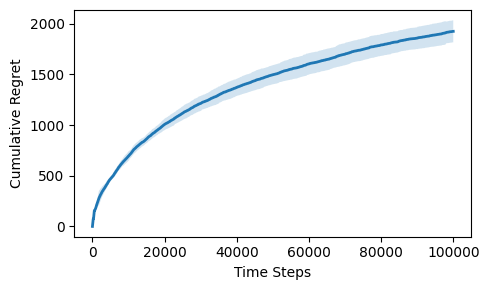

In [ ]:
# cu_regret = cu_regret1/1000
cu_regret1 = cu_regret
# Calculate mean and standard deviation of cumulative regrets
mean_regret1 = np.mean(cu_regret1, axis=0)
std_regret1 = np.std(cu_regret1, axis=0)

# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret1, linewidth=2)

# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret1 + std_regret1
                 ,mean_regret1 - std_regret1
                 , alpha=0.2)

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

In [ ]:
class UCB_algo:
    def __init__(self, bandit_env, alpha):
        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.counts = np.zeros(self.num_arms)
        self.means = np.zeros(self.num_arms)
        self.total_pulls = 0
        self.alpha = alpha

    def select_arm(self, round_number):
        if self.total_pulls < self.num_arms:
            return self.total_pulls

        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                ucb_values[arm] = float('inf')
            else:
                confidence_bound = np.sqrt(self.alpha / 2 * np.log(self.total_pulls) / self.counts[arm])
                ucb_values[arm] = self.means[arm] + confidence_bound

        return np.argmax(ucb_values)

    def update(self, arm, reward, observed):
        if observed:
            self.counts[arm] += 1
            self.means[arm] += (reward - self.means[arm]) / self.counts[arm]

        self.total_pulls += 1

    def update_regret(self, arm, cu_regret, regrets):
        regret = self.bandit_env.mu[self.bandit_env.best_arm] - self.bandit_env.mu[arm]

        cu_regret += regret  # Add this round's regret to the cumulative regret
        regrets.append(cu_regret)  # Store the cumulative regret
        return cu_regret

    def run(self, num_rounds):
        results = []
        regrets = []
        cu_regret = 0
        for round_number in range(num_rounds):
            arm = self.select_arm(round_number)

            reward_i, reward, observed, context = self.bandit_env.pull_arm(arm)

            cu_regret = self.update_regret(arm, cu_regret, regrets)
            self.update(arm, reward, observed)

            results.append((arm, reward, observed))

        return results, regrets

In [ ]:
np.random.seed(42)

# Parameters
T = 100000  # Time horizon
repeat = 10  # Number of repetitions

# Initialize cumulative regret storage
cu_regret2 = np.zeros((repeat, T))
all_results = []
algo = UCB_algo(bandit_env, 1)
# Run the algorithm for each repetition
for r in range(repeat):
    # Initialize and run the MAR algorithm
    algo = UCB_algo(bandit_env, 1)
    results, regrets = algo.run(T)
    all_results.append(results)

    # Store the cumulative regrets for this run
    cu_regret2[r] = regrets

In [ ]:
print(cu_regret2[0])
print(cu_regret2[1])

[ 0.39997645  0.74141601  0.74141601 ... 73.7609631  73.7609631
 73.7609631 ]
[ 0.39997645  0.74141601  0.74141601 ... 65.79977964 65.79977964
 65.79977964]


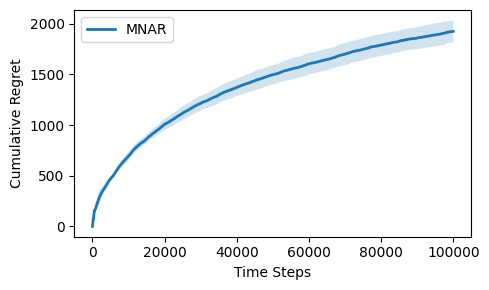

In [ ]:
# cu_regret2 /= 1000

# Calculate mean and standard deviation of cumulative regrets
mean_regret1 = np.mean(cu_regret1, axis=0)
std_regret1 = np.std(cu_regret1, axis=0)

mean_regret2 = np.mean(cu_regret2, axis=0)
std_regret2 = np.std(cu_regret2, axis=0)


# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret1, linewidth=2, label="MNAR")

# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret1 - std_regret1,
                 mean_regret1 + std_regret1
                 , alpha=0.2)

# Plot the mean cumulative regret
# plt.plot(mean_regret2, linewidth=2, label="UCB")

# Add shaded area for error indication (±2mean_regret2 standard deviation)
# plt.fill_between(np.arange(T),
#                  mean_regret2 - std_regret2,
#                  mean_regret2 + std_regret2
#                  , alpha=0.2)


# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)
plt.legend(loc='upper left')

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

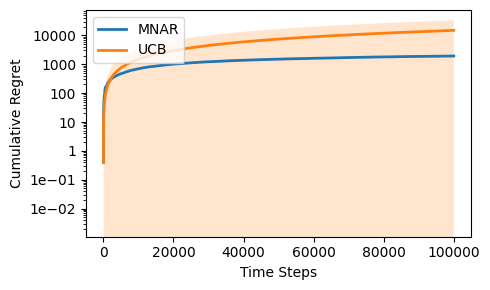

In [ ]:
import matplotlib.ticker as ticker

# Calculate mean and standard deviation of cumulative regrets
mean_regret1 = np.mean(cu_regret1, axis=0)
std_regret1 = np.std(cu_regret1, axis=0)

mean_regret2 = np.mean(cu_regret2, axis=0)
std_regret2 = np.std(cu_regret2, axis=0)

# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret1, linewidth=2, label="MNAR")

# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret1 - std_regret1,
                 mean_regret1 + std_regret1,
                 alpha=0.2)

# Plot the mean cumulative regret
plt.plot(mean_regret2, linewidth=2, label="UCB")

# Add shaded area for error indication (±1 standard deviation)
plt.fill_between(np.arange(T),
                 mean_regret2 - std_regret2,
                 mean_regret2 + std_regret2,
                 alpha=0.2)

# Set the y-axis to log scale
plt.yscale('log')

# Set the formatter for the y-axis to display in 10^n format
plt.gca().yaxis.set_major_formatter(ticker.LogFormatter(base=10))

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)
plt.legend(loc='upper left')

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('log_cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

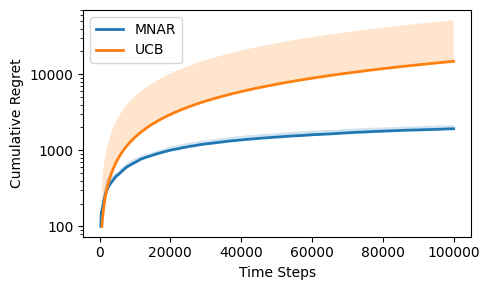

In [ ]:
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt

# Assuming cu_regret1 and cu_regret2 are already defined arrays
T = len(cu_regret1[0])  # Number of time steps, assuming cu_regret1 is a 2D array

# Calculate mean and standard deviation of cumulative regrets
mean_regret1 = np.mean(cu_regret1, axis=0)
std_regret1 = np.std(cu_regret1, axis=0)

mean_regret2 = np.mean(cu_regret2, axis=0)
std_regret2 = np.std(cu_regret2, axis=0)

# Create a mask to filter out points where mean regret is less than 100
mask_regret1 = mean_regret1 > 100
mask_regret2 = mean_regret2 > 100

# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret for MNAR where regret is greater than 100
plt.plot(np.arange(T)[mask_regret1], mean_regret1[mask_regret1], linewidth=2, label="MNAR")

# Add shaded area for error indication (±1 standard deviation), applying the mask
plt.fill_between(np.arange(T)[mask_regret1],
                 mean_regret1[mask_regret1],
                 mean_regret1[mask_regret1] + 2 * std_regret1[mask_regret1],
                 alpha=0.2)

# Plot the mean cumulative regret for UCB where regret is greater than 100
plt.plot(np.arange(T)[mask_regret2], mean_regret2[mask_regret2], linewidth=2, label="UCB")

# Add shaded area for error indication (±1 standard deviation), applying the mask
plt.fill_between(np.arange(T)[mask_regret2],
                 mean_regret2[mask_regret2],
                 mean_regret2[mask_regret2] + 2 * std_regret2[mask_regret2],
                #  mean_regret2[mask_regret2] - std_regret2[mask_regret2],
                 alpha=0.2)

# Set the y-axis to log scale
plt.yscale('log')

# Set the formatter for the y-axis to display in 10^n format
plt.gca().yaxis.set_major_formatter(ticker.LogFormatter(base=10))

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)
plt.legend(loc='upper left')

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('log_cumulative_regret_plot_paper_filtered.png', dpi=300)

# Display the plot
plt.show()


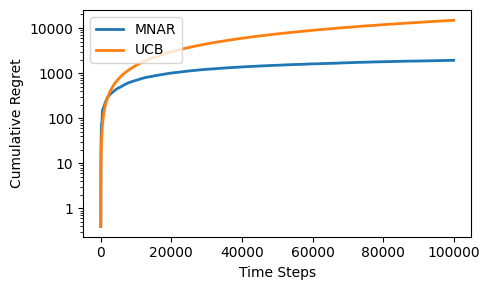

In [ ]:
import matplotlib.ticker as ticker

# Calculate mean and standard deviation of cumulative regrets
mean_regret1 = np.mean(cu_regret1, axis=0)
std_regret1 = np.std(cu_regret1, axis=0)

mean_regret2 = np.mean(cu_regret2, axis=0)
std_regret2 = np.std(cu_regret2, axis=0)

# Plot the average cumulative regret with error shading
plt.figure(figsize=(5, 3))

# Plot the mean cumulative regret
plt.plot(mean_regret1, linewidth=2, label="MNAR")

# Add shaded area for error indication (±1 standard deviation)
# plt.fill_between(np.arange(T),
#                  mean_regret1 ,
#                  mean_regret1 + std_regret1,
#                  alpha=0.2)

# Plot the mean cumulative regret
plt.plot(mean_regret2, linewidth=2, label="UCB")

# Add shaded area for error indication (±1 standard deviation)
# plt.fill_between(np.arange(T),
#                  mean_regret2 ,
#                  mean_regret2 + std_regret2,
#                  alpha=0.2)

# Set the y-axis to log scale
plt.yscale('log')

# Set the formatter for the y-axis to display in 10^n format
plt.gca().yaxis.set_major_formatter(ticker.LogFormatter(base=10))

# Add labels and grid
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')
plt.grid(False)
plt.legend(loc='upper left')

# Adjust the layout for better spacing
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('log_cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()